In [1]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
from models.tree_net import TreeNet
import numpy as np

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 2: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5105)


In [3]:
DS_SHAPE = (256, 256)
num_cascades = 4

model = TreeNet(num_cascades, DS_SHAPE)

In [8]:
X = np.ones((100, 1, 256, 256), dtype=np.float32)

In [4]:
model.predict(np.ones((600, 1, 256, 256), dtype=np.float32)).shape

(600, 11, 64, 64)

In [92]:
import theano 
import theano.tensor as T

inp = T.tensor4()
f1 = theano.function([inp], T.exp(inp))
f2 = theano.function([inp], T.exp(inp).sum(axis=1))

In [94]:
t = np.random.random(size=10 * 2*3*4).reshape((10, 2,3, 4)).astype(np.float32)
a = f1(t)
b = f2(t)

In [105]:
(a / b.reshape(-1, 1, 3, 4))[1, :, 0, 2].sum()

1.0

In [96]:
b.shape

(10, 3, 4)

In [95]:
a.shape

(10, 2, 3, 4)

In [73]:
model.train(np.ones((100, 1, 256, 256), dtype=np.float32), np.zeros((100, 11, 64, 64), dtype=np.float32))

array(-0.0, dtype=float32)

# Create Dataset

In [6]:
import matplotlib.pyplot as plt
import scipy as sp
import scipy.ndimage
from utils.mnist import load_dataset

%matplotlib inline

In [32]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

In [37]:
X = np.vstack([mnist[0], mnist[2], mnist[4]])
y = np.hstack([mnist[1], mnist[3], mnist[5]])

In [64]:
DS_SIZE = 10000
dataset = []
targets = []

for i in range(DS_SIZE):
    img = np.zeros(DS_SHAPE)
    
    sp.ndimage.zoom(X[0, 0], 2.5)
    
    dataset.append(img)

In [12]:
sp.ndimage.zoom(X[0, 0], 0.1).shape

/home/musvyatsov/muon_trigger/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


(26, 26)

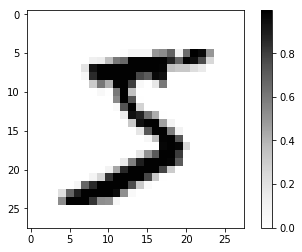

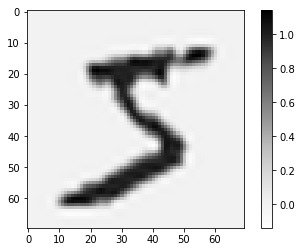

In [54]:
plt.imshow(X[0, 0], cmap = plt.cm.Greys)
plt.colorbar()
plt.show()

plt.imshow(sp.ndimage.zoom(X[0, 0], 0.5), cmap = plt.cm.Greys)
plt.colorbar()
plt.show()

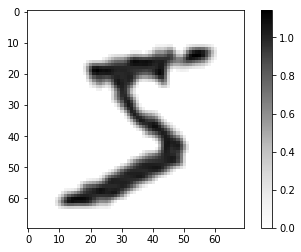

In [62]:
a = sp.ndimage.zoom(X[0, 0], 2.5)
a[a < 0.1] = 0.0

plt.imshow(a, cmap = plt.cm.Greys)
plt.colorbar()

In [63]:
X[0, 0]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.    

In [ ]:
%matplotlib inline